In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['figure.dpi'] = 300
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # 显示所有列
from tqdm.notebook import tqdm
import geopandas as gpd
import transbigdata as tbd
import geoplot as gplt

In [2]:
df_all = pd.read_csv('E:/Data/mobike201803/final_data.csv')

In [3]:
df_all.columns

Index(['poly_id', 'geometry', 'road_length', 'road_density', '交通设施服务', '住宿服务',
       '体育休闲服务', '公共设施', '公司企业', '医疗保健服务', '商务住宅', '地名地址信息', '摩托车服务',
       '政府机构及社会团体', '汽车服务', '汽车销售', '生活服务', '科教文化服务', '购物服务', '金融保险服务', '风景名胜',
       '餐饮服务', 'generate_trip_num', 'real_trip_num', 'poi_num', 'area',
       'samp_rate', 'grid_m', 'poi_density', 'trip_ratio'],
      dtype='object')

In [50]:
import statsmodels.api as sm
# 模型训练


# model.df_model

1.1265639658971165

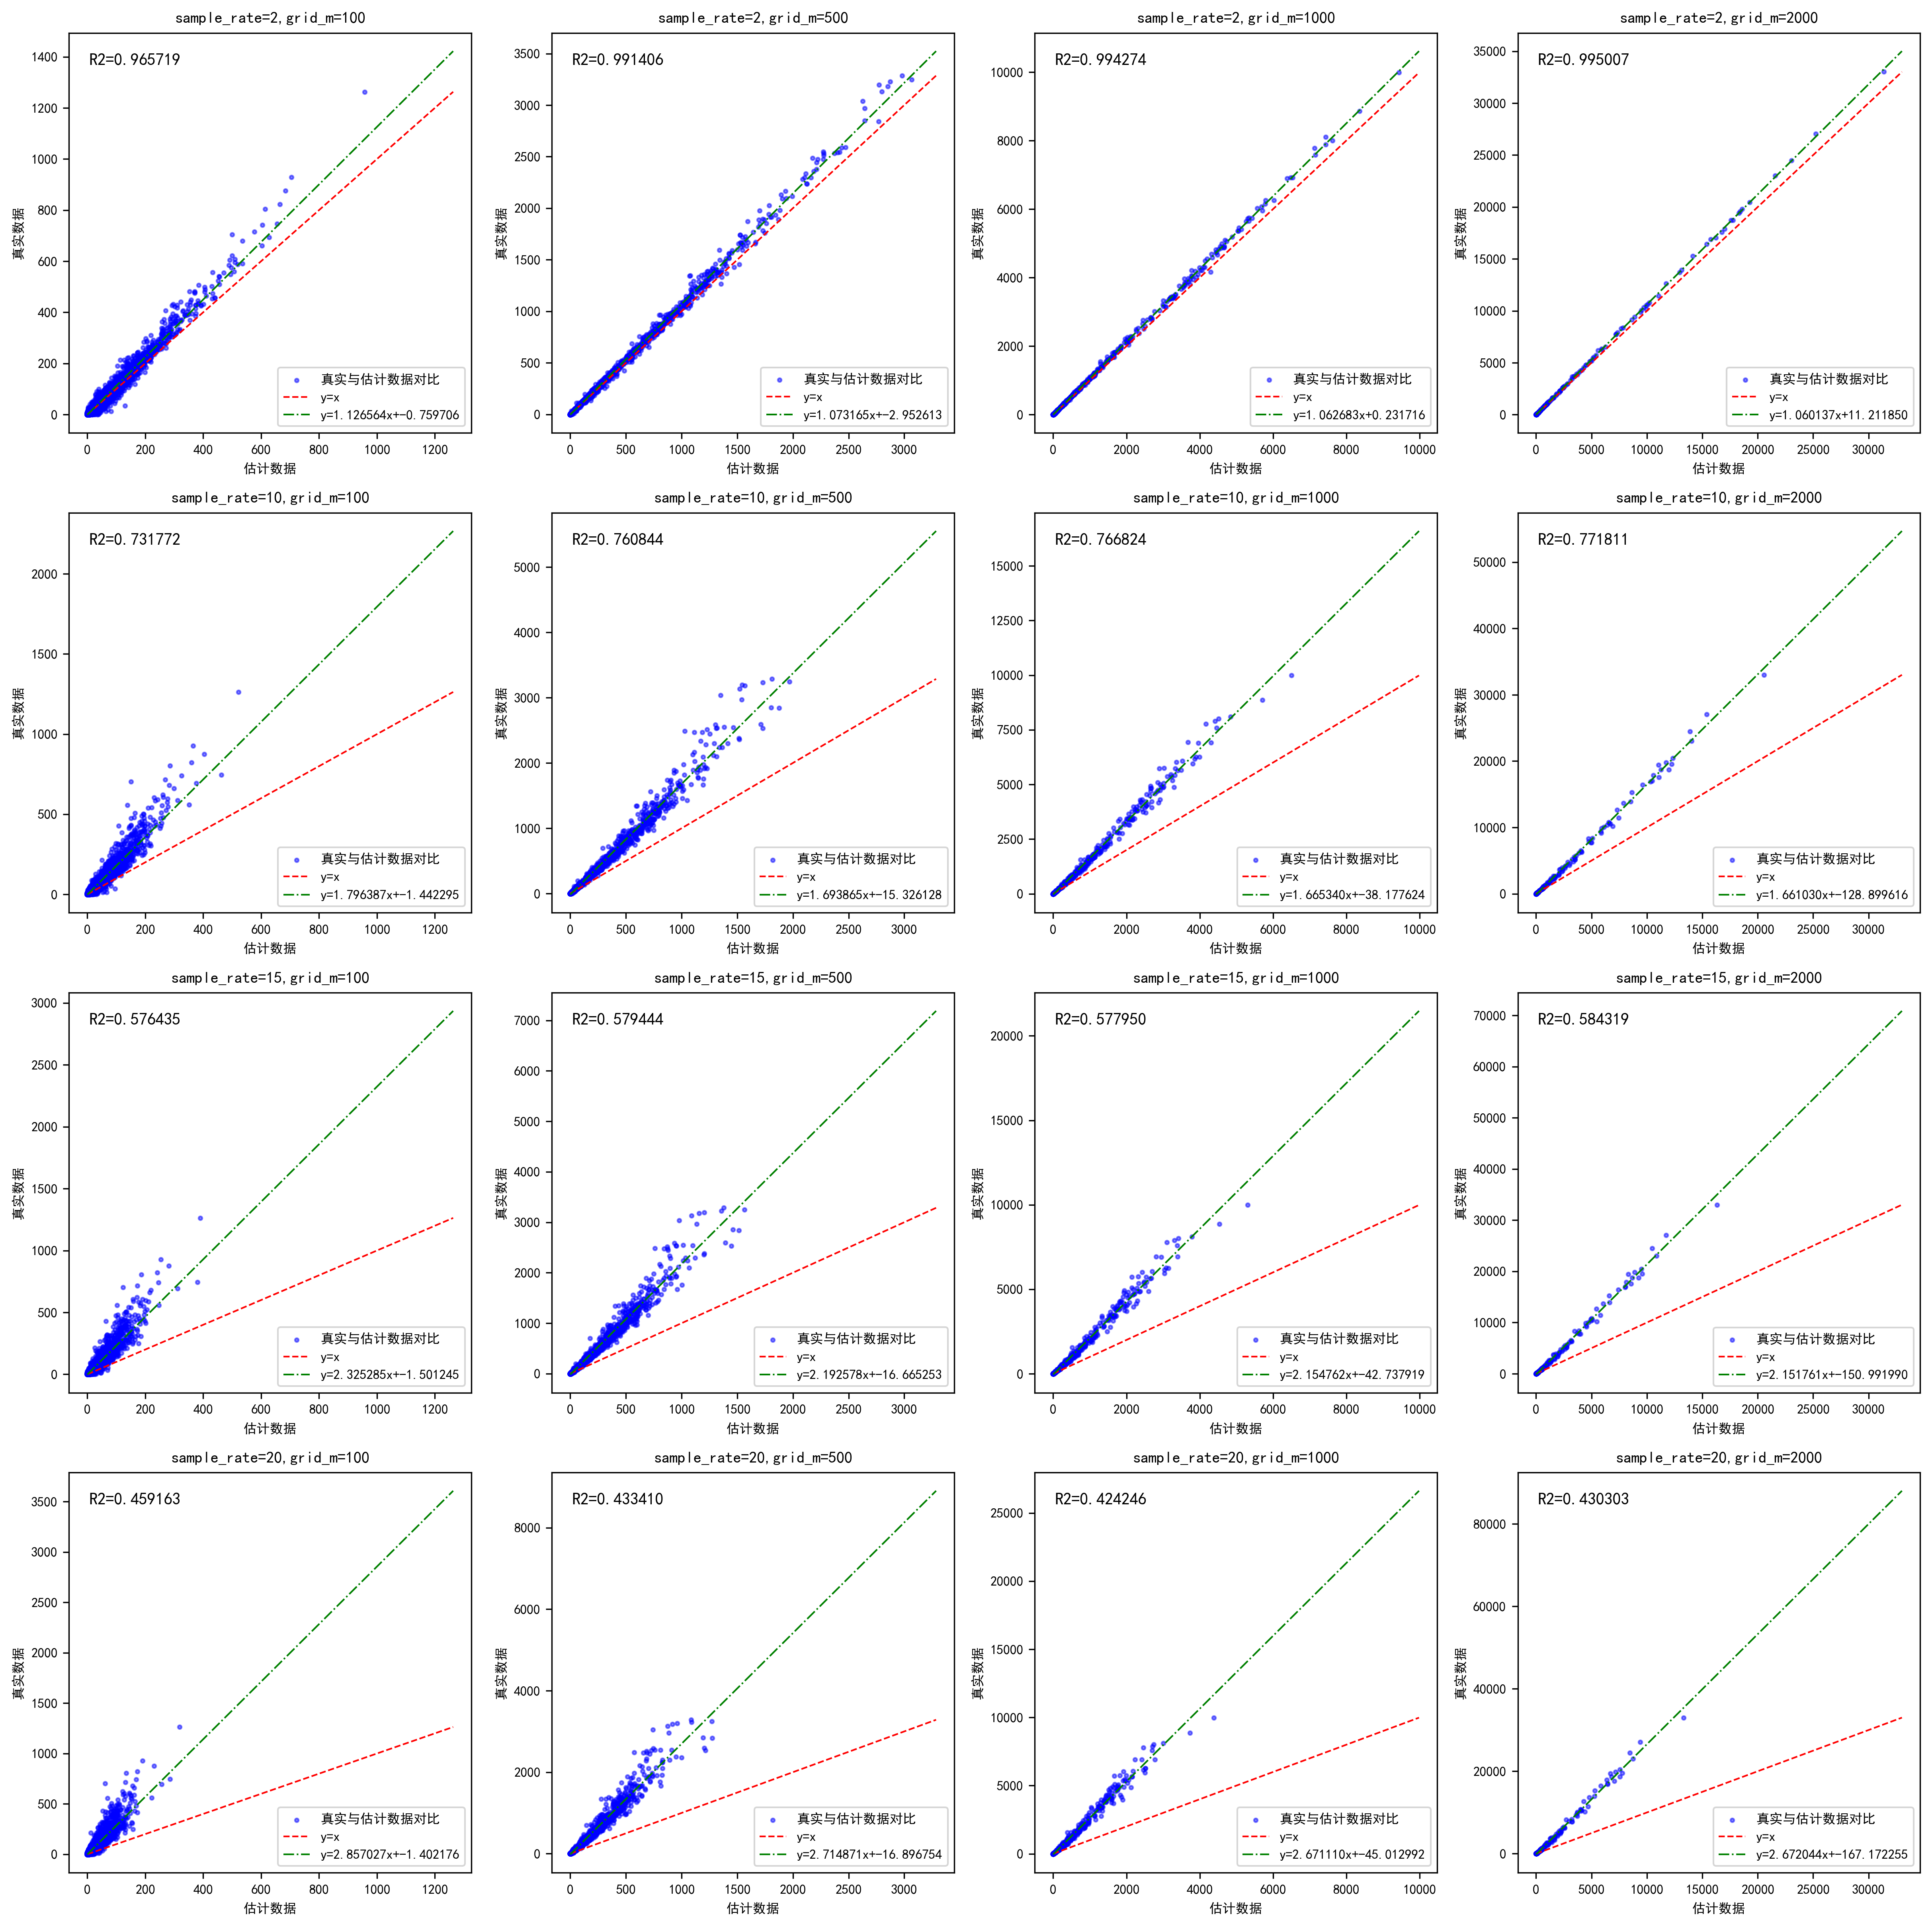

In [57]:
# 调整图片字号
plt.rcParams['font.size'] = '8'
# 计算R2
from sklearn.metrics import r2_score
fig, axes = plt.subplots(4,4, figsize=(20, 20))  # 可使用GridSpec用法
i=0
for sample_rate in [2,10,15,20]:
    j = 0
    for grid_m in [100,500,1000,2000]:
        ax = axes[i,j]
        df = df_all[(df_all['samp_rate']==sample_rate) & (df_all['grid_m']==grid_m)]
        ax.scatter(df['generate_trip_num'], df['real_trip_num'], s=5,label='真实与估计数据对比', alpha=0.5,color='blue')
        # 计算R2
        r2 = r2_score(df['real_trip_num'], df['generate_trip_num'])
        ax.text(0.05, 0.95, 'R2={:.6f}'.format(r2), transform=ax.transAxes, fontsize=10, verticalalignment='top')
        # 绘制y=x直线
        df_max = df[['generate_trip_num','real_trip_num']].max().max()
        ax.plot([0, df_max], [0, df_max], color='red', linewidth=1, linestyle='--',label='y=x')
        ax.set_xlabel('估计数据')
        ax.set_ylabel('真实数据')
        # 回归
        # sns.regplot(x='generate_trip_num', y='real_trip_num', data=df, ax=ax, color='green', scatter=False)
        # 计算线性回归的系数
        X = df.loc[:, 'generate_trip_num']
        X = sm.add_constant(X) 
        y = df.loc[:, 'real_trip_num']
        model = sm.OLS(y, X,hasconst=True).fit()
        # 画出回归直线
        x = np.linspace(0, df_max, 100)
        y = model.params[0] + model.params[1] * x
        ax.plot(x, y, color='green', linewidth=1, linestyle='dashdot',label='y={:.6f}x+{:.6f}'.format(model.params[1],model.params[0]))


        ax.legend(loc='lower right', ncol=1)
        # 标题
        ax.set_title('sample_rate={},grid_m={}'.format(sample_rate,grid_m))
        j += 1
    i += 1
# plt.savefig('C:/Users/yongqi/Desktop/真实与估计数据对比.jpg',dpi=600)
plt.show()

In [117]:
df_new = df_all[df_all.real_trip_num>0]
df_new['ratio_new'] = df_new.generate_trip_num / df_new.real_trip_num
dff = df_new.groupby(['samp_rate','grid_m'],as_index=False).agg({'ratio_new':'mean'})
dff

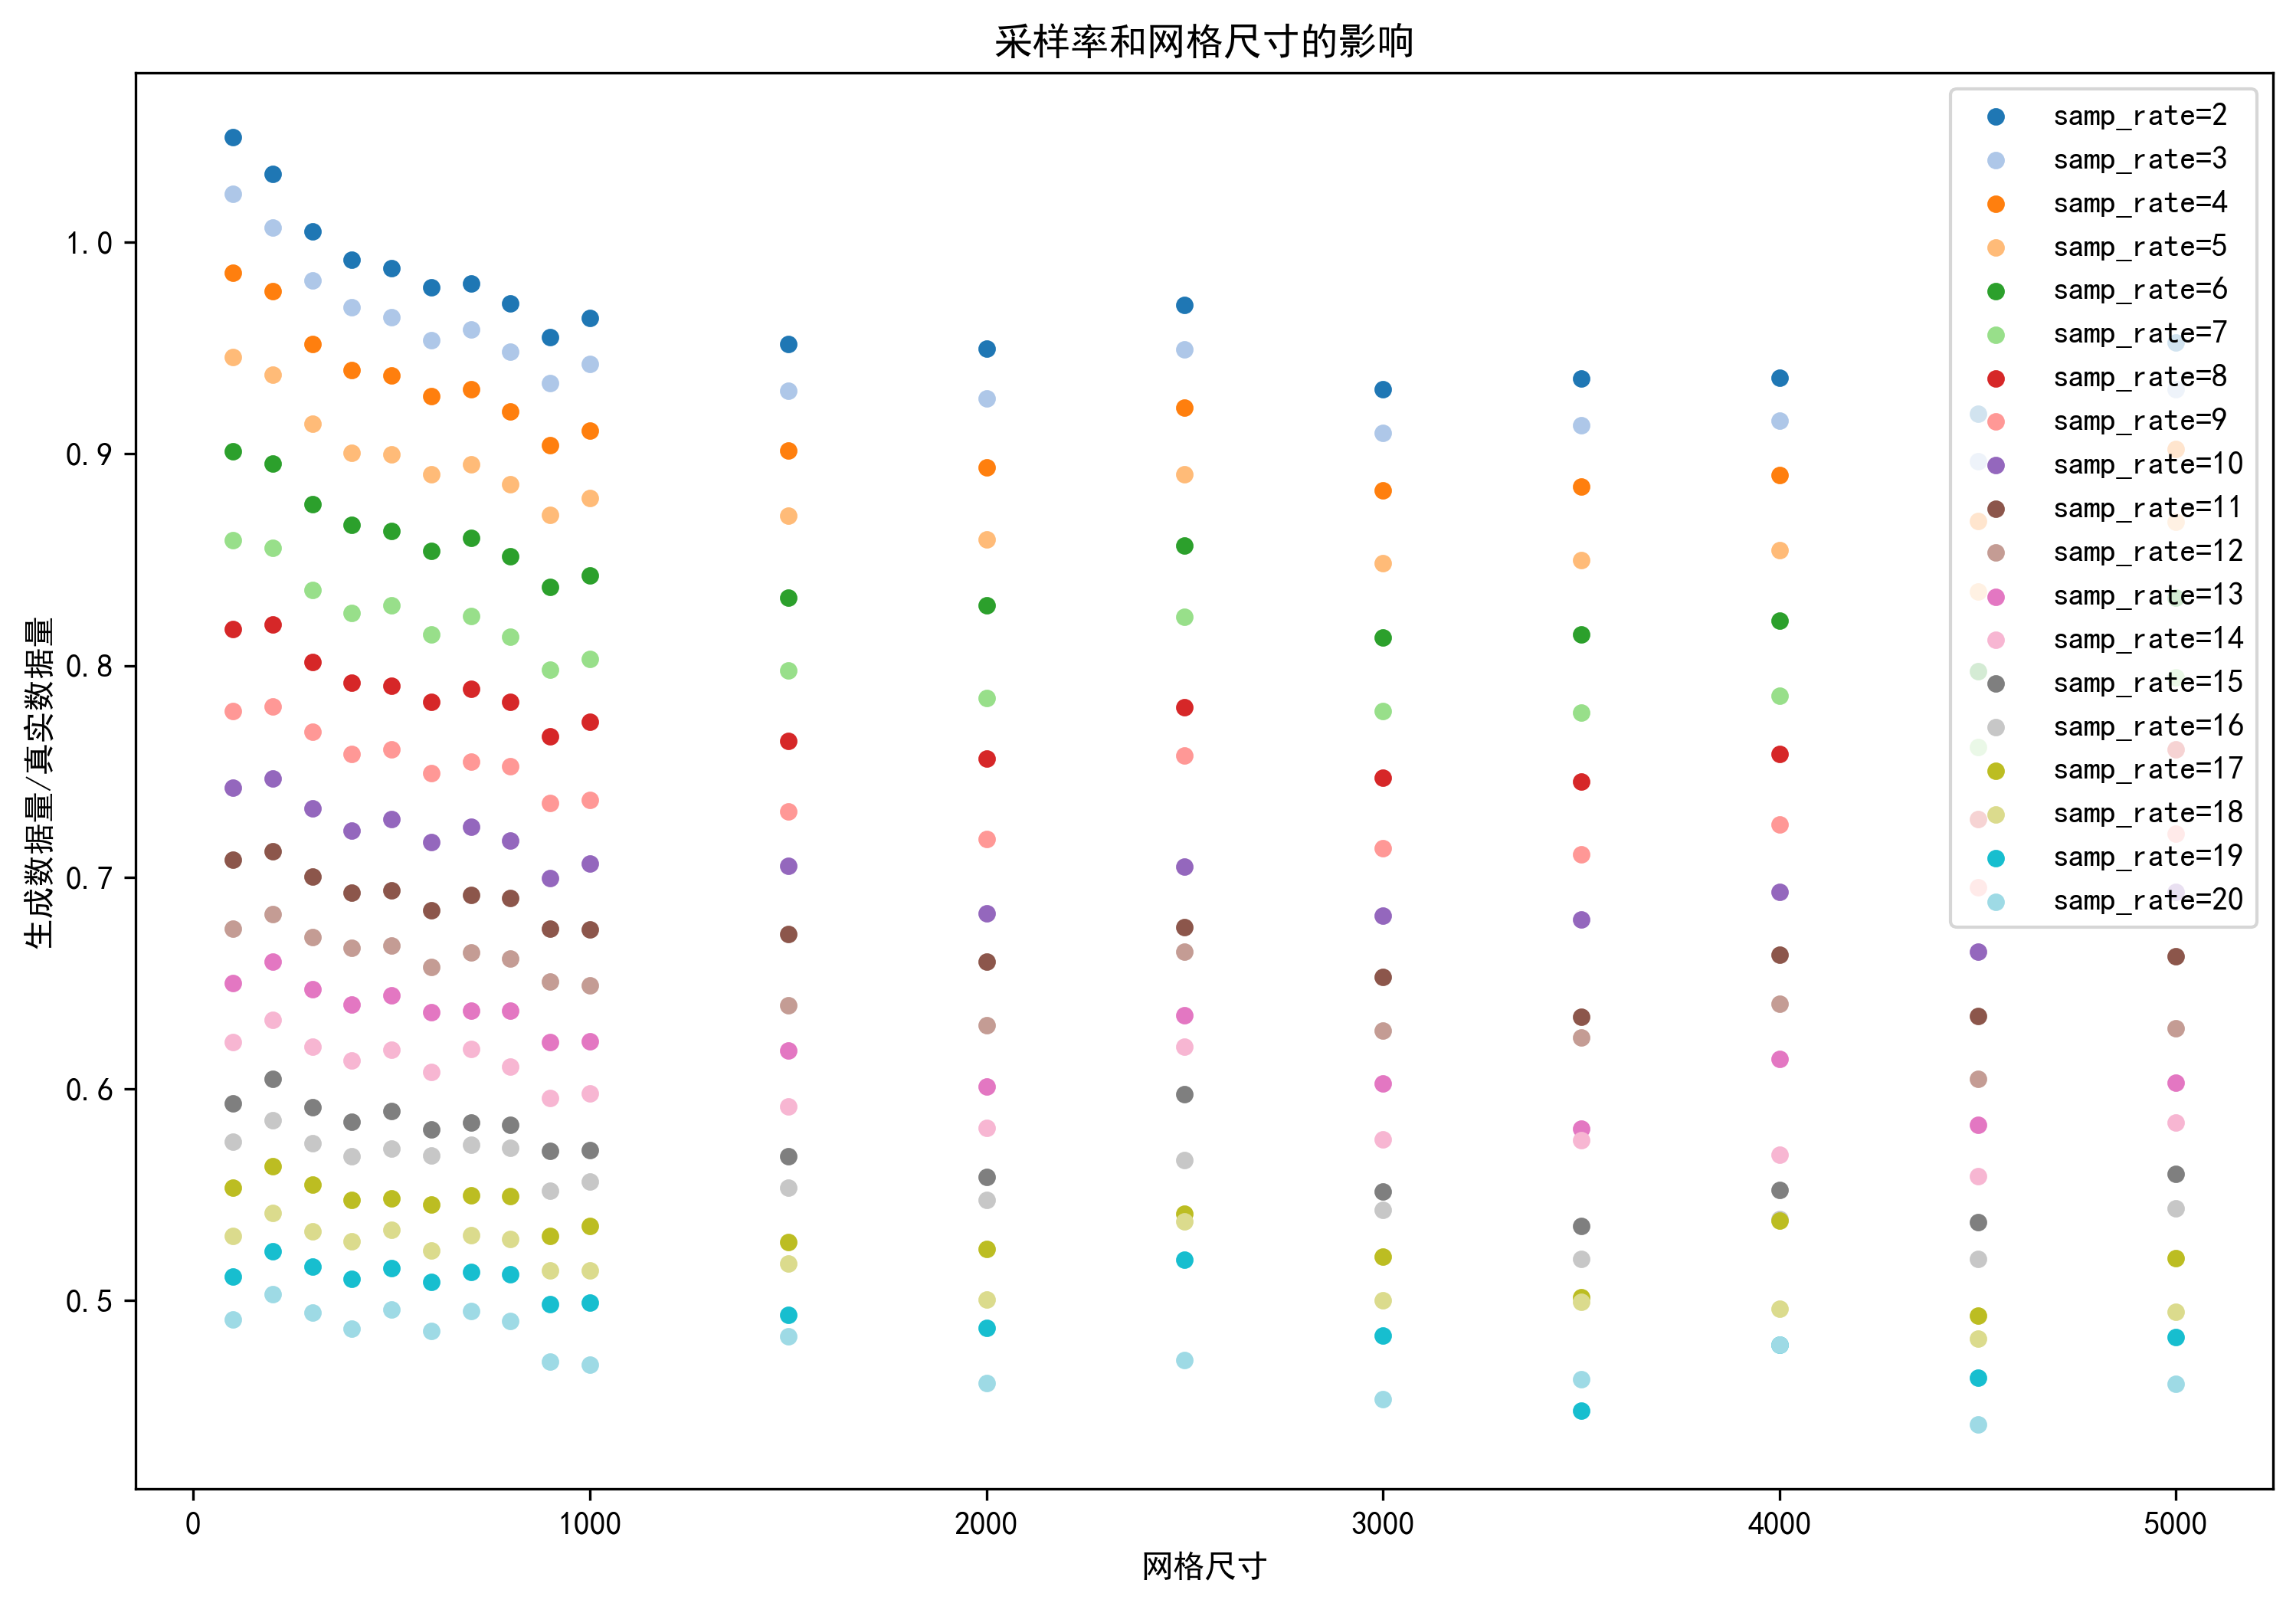

In [137]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 19)]
fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
for samp_rate,color_grid in zip(dff.samp_rate.unique(),colors):
    df = dff.query('samp_rate == {}'.format(samp_rate))
    df.plot(ax=ax, kind='scatter', x='grid_m', y='ratio_new',color=color_grid,label='samp_rate={}'.format(samp_rate))
plt.legend(loc='upper right')
ax.set_xlabel('网格尺寸')
ax.set_ylabel('生成数据量/真实数据量')
ax.set_title('采样率和网格尺寸的影响')
plt.savefig('C:/Users/yongqi/Desktop/采样率和网格尺寸的影响_网格尺寸.jpg',dpi=600)


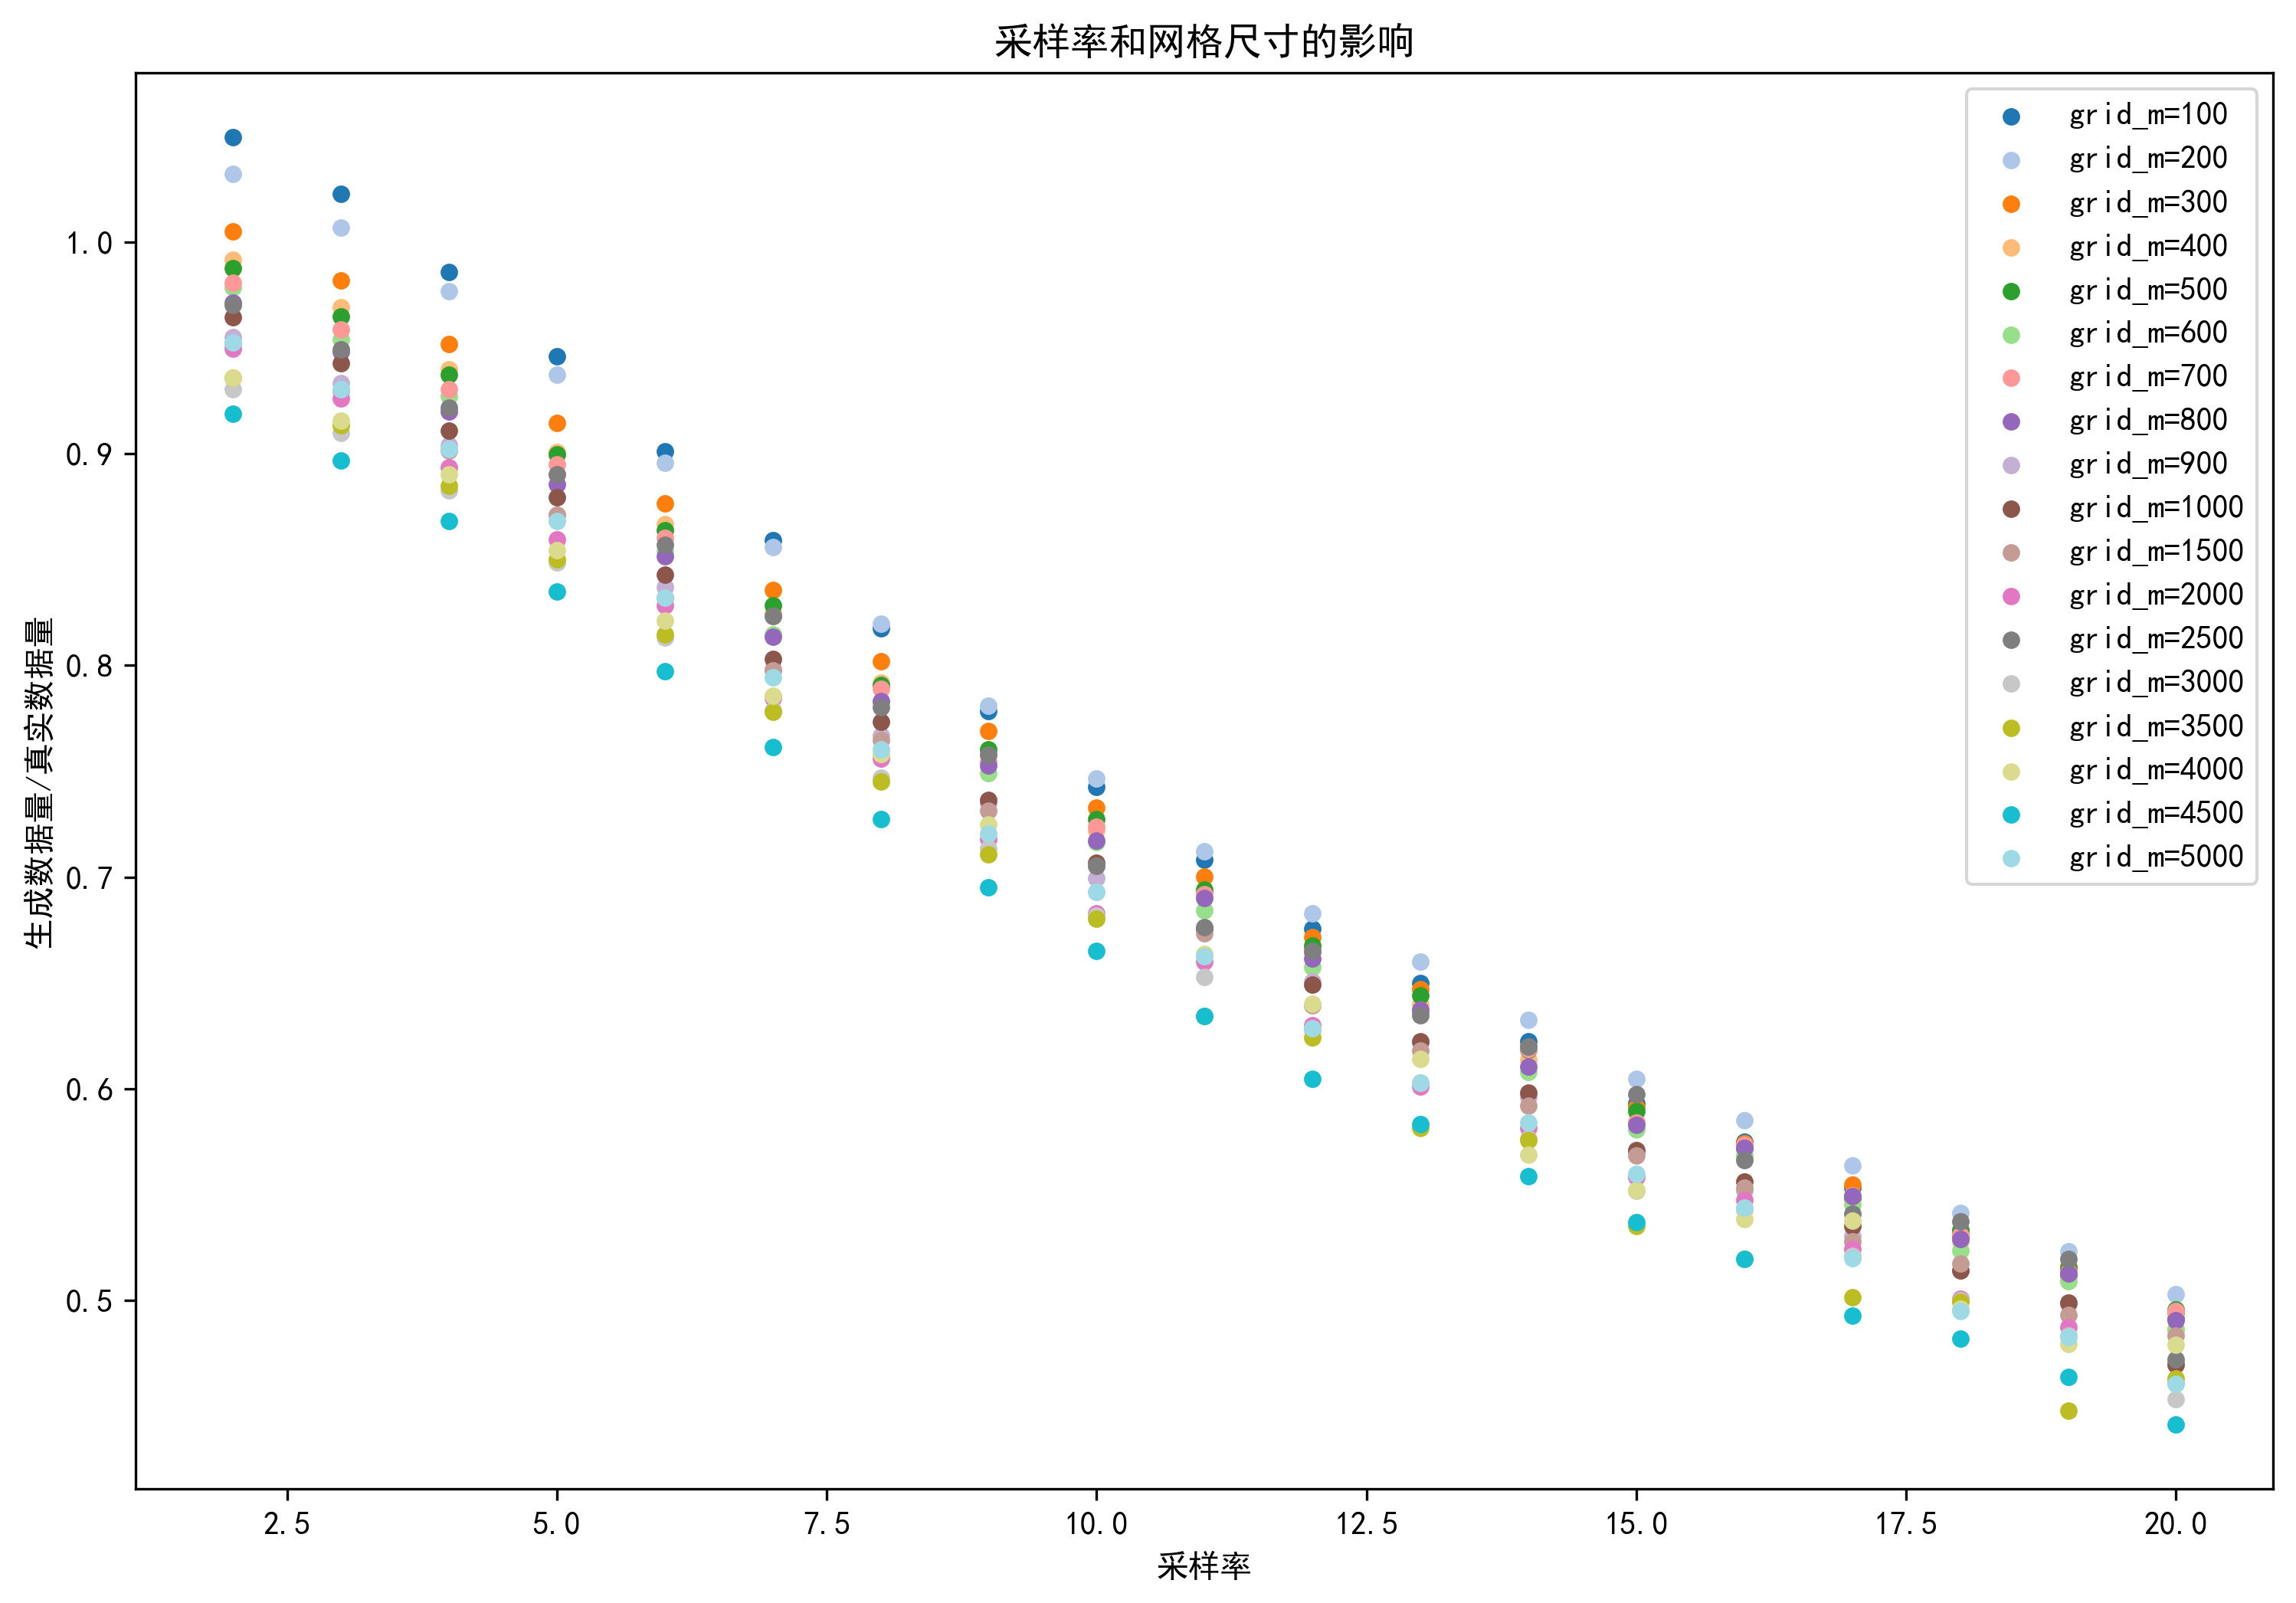

In [138]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 18)]
fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
for grid_m,color_grid in zip(dff.grid_m.unique(),colors):
    df = dff.query('grid_m == {}'.format(grid_m))
    df.plot(ax=ax, kind='scatter', x='samp_rate', y='ratio_new',color=color_grid,label='grid_m={}'.format(grid_m))
plt.legend(loc='best')
ax.set_xlabel('采样率')
ax.set_ylabel('生成数据量/真实数据量')
ax.set_title('采样率和网格尺寸的影响')
plt.savefig('C:/Users/yongqi/Desktop/采样率和网格尺寸的影响_采样率.jpg',dpi=600)